# SI 650 / EECS 549: Homework 2

## Introduction to PyTerrier and Weighting Functions

This homework is intended to expose you to other types of information retrieval and demonstrates the use of another state of the art IR library, [PyTerrier](https://github.com/terrier-org/pyterrier). 

The overall learning goals of the assignment across all tasks are
  - Learn how to install (and debug) new software libraries
  - Learn how to use PyTerrier  
  - Understand how to use document augmentation
  - Gain additional programming and debugging skills when working with modern IR libraries
  - Learn how weighting functions work and are implemented
  - Gain skills in experimentation and evaluation of IR models
  
Homework 2 will have you working on the following tasks to get you started:
  - PyTerrier installation & configuration
  - indexing a collection
  - accessing an index
  - using the `BatchRetrieve` transformer for searching an index
  - conducting an `Experiment`
  - Writing BM25 and Pivoted normalization from scratch as weighting functions
  - Writing your own custom weighting function

For all parts of the homework, you shoud run them on your local computer with enough time. We _strongly_ discourage running these on any remote system (e.g., colab) at the moment, as we have designed this homework in mind with helping you build the skills of installing and runnnig complex libraries.

For each notebook, all the programming tasks that you will need to complete are marked with **Task** in a cell title comment. You will need to do a bit of analysis and writing. Writing responses should be submitted in a **separate** document than the notebook.

Like many python-based IR frameworks, PyTerrier  uses a Java-based library underneith, [Terrier information retrieval toolkit](http://terrier.org), so you may need to set `JAVA_HOME` accordingly. Java is a high performance computing language and has a rich set of efficient implemenations for many indexing and retrieval operations. PyTerrier is relatively new in 2020, but Terrier has a long history dating back to 2001 and  makes it easy to perform IR experiments in Python, which could come in handy for you when doing your course project.

To complete the homework, you will need to see the [PyTerrier documentation](https://pyterrier.readthedocs.io/en/latest/) for many more details.

In [1]:
!pip install --upgrade fastrank lightgbm==3.1.1
!pip install python-terrier

  Using cached lightgbm-3.1.1-py2.py3-none-macosx_10_13_x86_64.macosx_10_14_x86_64.macosx_10_15_x86_64.whl (1.0 MB)

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 kB 2.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.3/276.3 kB 6.7 MB/s eta 0:00:00a 0:00:01


  Created wheel for python-terrier: filename=python_terrier-0.9.1-py3-none-any.whl size=110766 sha256=2244791faf14d91c558fd97cbb46d3d720f189a5e928b4150f88838e799c37c0
  Stored in directory: /Users/junsi/Library/Caches/pip/wheels/9e/26/80/c1a4c077dd7115b4b35c1443de7760ee1b7731d5909b110b5c
Successfully built python-terrier
  Attempting uninstall: pyjnius
    Found existing installation: pyjnius 1.3.0
    Uninstalling pyjnius-1.3.0:
      Successfully uninstalled pyjnius-1.3.0

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


### Imports

In [2]:
import pandas as pd
# Helpful for showing indexing information
pd.set_option('display.max_colwidth', 150)

import pyterrier as pt
import os

### Starting PyTerrier

The first step is to initialise PyTerrier using PyTerrier's `init()` method. The `init()` method will download Terrier's jar file (if it's not already) and then start the Java Virtual Machine. To avoid downstream complications, we check `started()` prior to calling `init()` to prevent multiple Terrier instances from running concurrently.

In [3]:
if not pt.started():
    pt.init()

PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


### Documents, Indexing and Indexes

PyTerrier typically works with Pandas dataframes for inputs. Let's create a toy set of documents in a dataframe to test. Note that the column name of `docno` is a special PyTerrier name that is the unique identifier for each document.

In [4]:
docs_df = pd.DataFrame([
        ["d1", "this is the first document of many documents"],
        ["d2", "this is another document"],
        ["d3", "the topic of this document is unknown"]
    ], columns=["docno", "text"])

docs_df

,docno,text
0,d1,this is the first document of many documents
1,d2,this is another document
2,d3,the topic of this document is unknown


Before any search engine can estimate which documents are most likely to be relevant for a given query, it must index the documents. 

In the following cell, we index the dataframe's documents. The index, with all its data structures, is written into a directory called `toydocs_index`. 

In [5]:
index_dir = './toydocs_index'
indexer = pt.DFIndexer(index_dir, overwrite=True)
index_ref = indexer.index(docs_df["text"], docs_df["docno"])
index_ref.toString()

'./toydocs_index/data.properties'

PyTerrier will generate a index in the `toydocs_index` directory and and we can list the files to see what kind of internal structure and files it made

In [5]:
os.listdir(index_dir)

['data.inverted.bf',
 'data.direct.bf',
 'data.lexicon.fsomaphash',
 'data.lexicon.fsomapfile',
 'data.properties',
 'data.document.fsarrayfile',
 'data.meta-0.fsomapfile',
 'data.meta.zdata',
 'data.meta.idx']

Though not necessary, we encourage you to take a look at some of these files. What's in them? Do they make any sense? For fun, it can be useful to go find the python (or Java) code that reads these files and try to understand what makes up the index.

Once we've generated the files associated with `index_ref`, we can load the information into an actual PyTerrier index using the method `pt.IndexFactory.of()`. 

In [6]:
index = pt.IndexFactory.of(index_ref)

See Terrier's [`Index`](http://terrier.org/docs/current/javadoc/org/terrier/structures/Index.html) object for documentation, which is written in Java's Javadoc format. We can call these methods on our index object as well. Important methods to note are:
 - `getCollectionStatistics()`
 - `getInvertedIndex()`
 - `getLexicon()`

Let's see what is returned by the `CollectionStatistics()` method:

In [7]:
print(index.getCollectionStatistics().toString())

Number of documents: 3
Number of terms: 4
Number of postings: 6
Number of fields: 0
Number of tokens: 7
Field names: []
Positions:   false



Let's unpack the statistics a bit more. We have 3 documents but why do we have only 4 unique terms? We can look at which terms we have by getting the [`Lexicon`](http://terrier.org/docs/current/javadoc/org/terrier/structures/Lexicon.html) object, which contains our vocabulary. We can iterate over the `Lexicon` from Python like a dictionary to see which terms are present and whaht information there is about each term after indexing.

In [8]:
for kv in index.getLexicon():
    # Let's all print the type information of each to get a sense of what we're working with
    print("%s (%s) -> %s (%s)" % (kv.getKey(), type(kv.getKey()), kv.getValue().toString(), type(kv.getValue()) ) )

document (<class 'str'>) -> term0 Nt=3 TF=4 maxTF=2 @{0 0 0} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
first (<class 'str'>) -> term1 Nt=1 TF=1 maxTF=1 @{0 0 7} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
topic (<class 'str'>) -> term2 Nt=1 TF=1 maxTF=1 @{0 1 1} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
unknown (<class 'str'>) -> term3 Nt=1 TF=1 maxTF=1 @{0 1 5} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)


Iterating over the `Lexicon` shows that we're mapping a `String ` term to a [`LexiconEntry`](http://terrier.org/docs/current/javadoc/org/terrier/structures/LexiconEntry.html) object, which itself is an [`EntryStatistics`](http://terrier.org/docs/current/javadoc/org/terrier/structures/EntryStatistics.html). The `LexiconEntry` contains information including the statistics of that term.

Looking at what we indexed reveals that PyTerrier is removing stopwords for us, much like Pyserini did. PyTerrier is also doing some token normalization as well so that we only have "document" in our index, even though document `d1` has the token "documents"! By default Terrier removes standard stopwords and applies Porter's stemmer (which we talked about in class), though these behaviors can be configured.

The `EntryStatistics` also provides a few other fields that offer insights:
 - `Nt` is the number of unique documents that each term occurs in – this is useful for calculating IDF.
 - `TF` is the total number of occurrences – some weighting models use this instead of Nt.
 - The numbers in the `@{}` are a pointer – they tell Terrier where the postings are for that term in the inverted index data structure.

PyTerrier also supports directly looking up a word using the `[]` operator, much like we would if we were looking up a key's value in a dictionary. Let's look up the value for the word "document":

In [9]:
print(index.getLexicon()["document"])

term0 Nt=3 TF=4 maxTF=2 @{0 0 0}


We can use the information in the `Lexicon` to also look up documents as well. Remember from class that an inverted index is a mapping from a term to which *documents* each term occurs in. The `LexiconEntry` for a word contains the pointer to where to find the documents for that word in the inverted index. 

The object retrieved from using the `[]` operator with a `Lexicon` is a pointer that we can use with the inverted index.

In [10]:
pointer = index.getLexicon()["document"]
for posting in index.getInvertedIndex().getPostings(pointer):
    print(str(posting) + " doclen=%d" % posting.getDocumentLength())

ID(0) TF(2) doclen=3
ID(1) TF(1) doclen=1
ID(2) TF(1) doclen=3


From this output, we can see that the term "document" occurs in all three documents, as well as how long those documents are. Note that PyTerrier starts counting indexed documents with `int` values starting from 0 (called *docids*). These *docids* are then mapped back to *docnos*, which are the unique string identifiers for a document, e.g., the "`d1`", "`d2`" we used. This mapping is stored in a separate data structure called the *metaindex*, though you likely won't need to use that.

## Searching an Index

Our way into search in PyTerrier is called `BatchRetrieve`. BatchRetrieve is configured by specifying an index and a weighting model. Here', we'll use the `Tf` weighting, which is just term frequency; there are multiple possible weighting schemes, as we'll see later. Using a `BatchRetrieve` object, we will search for a single-word query, `"document"`.

In [11]:
br = pt.BatchRetrieve(index, wmodel="Tf")
br.search("document")

,qid,docid,docno,rank,score,query
0,1,0,d1,0,2.0,document
1,1,1,d2,1,1.0,document
2,1,2,d3,2,1.0,document


The `search()` method returns a Pandas dataframe with columns:
 - `qid`: this is the query id, which is by default "1", since we issued only one query
 - `docid`: Terrier' internal integer for each document
 - `docno`: the external (string) unique identifier for each document
 - `score`: since we use the `Tf` weighting model, this score corresponds the total frequency of the query (terms) in each document
 - `rank`: A handy attribute showing the descending order by score
 - `query`: the input query

As expected, the `Tf` weighting model used here only counts the frequencies of the query terms in each document, i.e.:
$$
score(d,q) = \sum_{t \in q} tf_{t,d}
$$
This is the "Raw TF" model we discussed in class! 

Hence, it's clear that document `d1` should be the highest scored document with two occurrences (c.f. `'document'` and `'documents'`).  

### Searching with multiple queries

We can search for more than one query at a time using the  `transform()` method rather than the `search()` method. PyTerrier uses the notion of transformers, which we'll describe much more in Part 2, but for now, you can think of this function as transforming some input to some output. In our case, we'll create a Pandas DataFrame with our queries, which we'll provide as input to the `BatchRetrieve` object, to "tranform" into results.

Note that we not only need to provide queries, but also query identifiers in the `qid` column. These `qid` values will let us distinguish which results go to which query.

In [12]:
queries = pd.DataFrame([["q1", "document"], ["q2", "first document"]], columns=["qid", "query"])
queries

,qid,query
0,q1,document
1,q2,first document


Now we can pass this queries data frame into `transform()` to get the results

In [13]:
br.transform(queries)

,qid,docid,docno,rank,score,query
0,q1,0,d1,0,2.0,document
1,q1,1,d2,1,1.0,document
2,q1,2,d3,2,1.0,document
3,q2,0,d1,0,3.0,first document
4,q2,1,d2,1,1.0,first document
5,q2,2,d3,2,1.0,first document


Most common operations in PyTerrier have be overloaded so that you can call them using python syntax (called _operator overloading_). We'll discuss this more in Part 2, but for now, know that you can call `br.transform(queries)` using just `br(queries)`. Here. the `()` operator has been overloaded so that it calls `transform()` for us! You will see this usage very frequently in examples and documentation so it's worth noting and remembering the two are equivalent. As an example:

In [14]:
br(queries)

,qid,docid,docno,rank,score,query
0,q1,0,d1,0,2.0,document
1,q1,1,d2,1,1.0,document
2,q1,2,d3,2,1.0,document
3,q2,0,d1,0,3.0,first document
4,q2,1,d2,1,1.0,first document
5,q2,2,d3,2,1.0,first document


That gives us the exact same results as our earlier call to `br.transform(queries)`, just like we expect.

## Working with real data

Let's move on to our full dataset, the NF Corpus (Nutrition Facts), which is easily accessible online. We'll use PyTerrier's `get_dataset()` function to download this corpus automatically and then to index it. This dataset is designed to test IR in a full-text English retrieval setting for Medical Information Retrieval. We'll use this for the initial two groups of tasks and then switch datasets later.
 
### Task 1.1 (5 points):

You first task will be to write three lines of code that create the index using an indexer or, if the index was already created, loads the created index from file. 

In [5]:
nf_dataset = pt.datasets.get_dataset('irds:nfcorpus/dev') 
pt_index_path = './nfcorpus_dev'

if not os.path.exists(pt_index_path + "/data.properties"):

    # create the index, using the IterDictIndexer indexer 
    # TODO
    iter_indexer = pt.IterDictIndexer(pt_index_path)

    # we give the dataset get_corpus_iter() directly to the indexer
    # while specifying the fields to index and the metadata to record   
    # TODO
    index_ref = iter_indexer.index(nf_dataset.get_corpus_iter(), fields = ('abstract', ), meta=('docno', ))

else:
    # if you already have the index, create an IndexRef from the data in pt_index_path
    # that we can use to load using the IndexFactory
    # TODO
    index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")
    
index = pt.IndexFactory.of(index_ref)

### Task 1.2 (0 points but useful still)
- Print out the statistics of the index

In [6]:
# TODO
print(index.getCollectionStatistics().toString())

Number of documents: 5371
Number of terms: 18315
Number of postings: 499136
Number of fields: 1
Number of tokens: 801411
Field names: [abstract]
Positions:   false



As a curated collection for evaluation, NFCorpus has a corresponding set of queries, referred to as _topics_, and the relevance assessments for each query (i.e., topic), referred to as _qrels_. We use these to evaluation as a *test collection*. PyTerrier allows us to easily access the topics (queries) and qrels from the dataset. Like much of the inputs and outputs, these are expressed as dataframes as well:

In [17]:
nf_dataset.get_topics(variant='title').head(5)

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


,qid,query
0,PLAIN-1,why deep fried foods may cause cancer
1,PLAIN-1007,ddt
2,PLAIN-101,how to treat multiple sclerosis with diet
3,PLAIN-1017,detoxification
4,PLAIN-1027,dietary guidelines


In [18]:
nf_dataset.get_qrels().head(5)

,qid,docno,label,iteration
0,PLAIN-1,MED-2421,3,0
1,PLAIN-1,MED-2422,3,0
2,PLAIN-1,MED-2416,3,0
3,PLAIN-1,MED-2423,3,0
4,PLAIN-1,MED-2417,3,0


### Task 1.3: Build indices for the same documents with different preprocessing steps (5 points)

In homework 1, you tried out different approaches to filtering and tokenizing. What effect might these have in practice on a real index&mdash;and critically, on retrieval performance? PyTerrier supports modifying how an index is preprocessed via its [Indexing Configuration](https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html#indexing-configuration) options. 

Your task is to build *at least two* different versions of the NFCorpus index using different preprocessing steps. You are free to chose different configurations that might interest you. Once you have finished, print out the statistics below

In [19]:
# TODO

# configuration 1: 
# stemming configuation or stopwords: termpipelines - PorterStemmer
# languages and tokenisation: tokeniser - UTFTokeniser

pt_index_path1 = './nfcorpus1_dev'
if not os.path.exists(pt_index_path1 + "/data.properties"):
    iter_indexer1 = pt.IterDictIndexer(pt_index_path1)
    iter_indexer1.setProperty("termpipelines","PorterStemmer")
    iter_indexer1.setProperty("tokeniser", "UTFTokeniser")
    index_ref1 = iter_indexer1.index(nf_dataset.get_corpus_iter(), fields = ('abstract', ), meta=('docno', ))
else:
    index_ref1 = pt.IndexRef.of(pt_index_path1 + "/data.properties")
    
index1 = pt.IndexFactory.of(index_ref1)

print(index1.getCollectionStatistics().toString())

Number of documents: 5371
Number of terms: 18678
Number of postings: 671117
Number of fields: 1
Number of tokens: 1262132
Field names: [abstract]
Positions:   false



In [20]:
# TODO

# configuration 2: 
# stemming configuation or stopwords: termpipelines - Stopwords
# languages and tokenisation: tokeniser - UTFTokeniser

pt_index_path2 = './nfcorpus2_dev'
if not os.path.exists(pt_index_path2 + "/data.properties"):
    iter_indexer2 = pt.IterDictIndexer(pt_index_path2)
    iter_indexer2.setProperty("termpipelines", "Stopwords")
    iter_indexer2.setProperty("tokeniser", "UTFTokeniser")
    index_ref2 = iter_indexer2.index(nf_dataset.get_corpus_iter(), fields = ('abstract', ), meta=('docno', ))
else:
    index_ref2 = pt.IndexRef.of(pt_index_path2 + "/data.properties")
    
index2 = pt.IndexFactory.of(index_ref2)

print(index2.getCollectionStatistics().toString())

Number of documents: 5371
Number of terms: 25522
Number of postings: 530609
Number of fields: 1
Number of tokens: 802157
Field names: [abstract]
Positions:   false



In [21]:
# TODO

# configuration 3: 
# stemming configuation or stopwords: termpipelines - PorterStemmer
# languages and tokenisation: tokeniser - UTFTwitterTokeniser

pt_index_path3 = './nfcorpus3_dev'
if not os.path.exists(pt_index_path3 + "/data.properties"):
    iter_indexer3 = pt.IterDictIndexer(pt_index_path3)
    iter_indexer3.setProperty("termpipelines","Stopwords")
    iter_indexer3.setProperty("tokeniser", "UTFTwitterTokeniser")
    index_ref3 = iter_indexer3.index(nf_dataset.get_corpus_iter(), fields = ('abstract', ), meta=('docno', ))
else:
    index_ref3 = pt.IndexRef.of(pt_index_path3 + "/data.properties")
    
index3 = pt.IndexFactory.of(index_ref3)

print(index3.getCollectionStatistics().toString())

Number of documents: 5371
Number of terms: 26492
Number of postings: 530372
Number of fields: 1
Number of tokens: 800475
Field names: [abstract]
Positions:   false



### Task 1.4 Write-up your observations on what differs between them (5 points)

What effect did the preprocessing have on the index? You should look at the statistics but you can also comment on performance things like file sizes and indexing time. In *at least 4 sentences* describe what differences you see and whether you were surprised by any.

In [22]:
# TODO in your write-up

# see si650_hw2_sijuntao.pdf

### Weighting Models

In the earlier example, we used the simple "`Tf`" as our ranking function for document retrieval in BatchRetrieve. However, we can use other models such as `"TF_IDF"` by simply changing the `wmodel="Tf"` keyword argument in the constructor of `BatchRetrieve`:

In [23]:
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
tfidf.search("chemical reactions")

,qid,docid,docno,rank,score,query
0,1,4523,MED-4524,0,6.382897,chemical reactions
1,1,440,MED-441,1,6.203472,chemical reactions
2,1,3267,MED-3268,2,6.203472,chemical reactions
3,1,3281,MED-3282,3,6.203472,chemical reactions
4,1,4903,MED-4904,4,6.171522,chemical reactions
...,...,...,...,...,...,...
420,1,3944,MED-3945,420,1.909530,chemical reactions
421,1,1347,MED-1348,421,1.860415,chemical reactions
422,1,3718,MED-3719,422,1.849169,chemical reactions
423,1,869,MED-870,423,1.822288,chemical reactions


Note that, as expected, because we switched the ranking, the scores of documents ranked by `TF_IDF` are no longer integers. You can see the exact TF-IDF formula used by Terrier from [the Github repo](https://github.com/terrier-org/terrier-core/blob/5.x/modules/core/src/main/java/org/terrier/matching/models/TF_IDF.java#L79)--sometimes helpful to know since there are multiple ways of defining TF-IDF! Terrier supports many weighting models and the documentation contains [a list of supported models](http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html).

## Evaluating and Comparing IR Models

How do we know which of the models we've made so far are good IR models? PyTerrier provides a robust and extensive framework to help us automate the evaluation of IR models once wee've defined them.

As a first pass, let's take a look at the relevance scores in the dataset. To do this, we'll merge (`join`) the `qrels` with the results of our ranker to produce a dataframe that has both the ranking model's predictions (`"score"`) and the actual relevance score (`"label"`). 

In [24]:
qrels = nf_dataset.get_qrels()

def get_res_with_labels(ranker, df):
    # get the results for the query or queries
    results = ranker( df )
    # left outer join with the qrels
    with_labels = results.merge(qrels, on=["qid", "docno"], how="left").fillna(0)
    return with_labels

# lets get the Tf results for the first query
get_res_with_labels(tfidf, nf_dataset.get_topics(variant='title').head(1))

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


,qid,docid,docno,rank,score,query,label,iteration
0,PLAIN-1,5,MED-6,0,18.407378,why deep fried foods may cause cancer,0.0,0
1,PLAIN-1,2417,MED-2418,1,18.407378,why deep fried foods may cause cancer,3.0,0
2,PLAIN-1,5268,MED-5269,2,13.991407,why deep fried foods may cause cancer,0.0,0
3,PLAIN-1,2414,MED-2415,3,12.303626,why deep fried foods may cause cancer,0.0,0
4,PLAIN-1,4063,MED-4064,4,12.303626,why deep fried foods may cause cancer,0.0,0
...,...,...,...,...,...,...,...,...
995,PLAIN-1,830,MED-831,995,3.092051,why deep fried foods may cause cancer,0.0,0
996,PLAIN-1,984,MED-985,996,3.088660,why deep fried foods may cause cancer,0.0,0
997,PLAIN-1,4510,MED-4511,997,3.084229,why deep fried foods may cause cancer,0.0,0
998,PLAIN-1,3872,MED-3873,998,3.081767,why deep fried foods may cause cancer,0.0,0


### Running an Experiment

We don't actually need to produce that dataframe to do our evaluation though! PyTerrier lets us run different results with an [Experiment](https://pyterrier.readthedocs.io/en/latest/experiments.html) object, which will compare models according to the evaluation metrics we specify. Here, let's run an experiment to evaluate our `tfidf` model that we created earlier:

In [25]:
pt.Experiment(
    [tfidf],
    nf_dataset.get_topics(variant='title'),
    nf_dataset.get_qrels(),
    eval_metrics=["map", "ndcg"])

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


,name,map,ndcg
0,BR(TF_IDF),0.087904,0.227368


## Task 2.1: Define new models and evaluate them in an Experiment (5 points)

Now comes the fun part! Your task is to define **three** new [`BatchRetrieve`](https://pyterrier.readthedocs.io/en/latest/terrier-retrieval.html#batchretrieve) objects with different word ranking methods. You are welcome to set the hyperparameters but all models should be sufficiently different. You are definitely welcome (encouraged, even!) to compare _more_ than three models too.

Once you have defined your three `BatchRetrieve` objects, conduct an `Experiment` using all of them _at once_ (not three separate `Experiment` runs!) to evlauate the results.  Your experiment should include the two metrics used above, as well as NDCG for the top-5 and top-10 results. You are welcome to include other metrics as well

Print the results of each Experiment 

In [26]:
# TODO: Compare existing models
from pyterrier.measures import *

bm25 = pt.BatchRetrieve(index, wmodel="BM25")
dph = pt.BatchRetrieve(index, wmodel="DPH")
hiemstra_lm = pt.BatchRetrieve(index, wmodel="Hiemstra_LM")
dfic = pt.BatchRetrieve(index, wmodel="DFIC")
pl2 = pt.BatchRetrieve(index, wmodel="PL2")

pt.Experiment(
    [bm25, dph, hiemstra_lm, dfic, pl2],
    nf_dataset.get_topics(variant='title'),
    nf_dataset.get_qrels(),
    eval_metrics=["map", "ndcg", nDCG@5, nDCG@10, "recip_rank"])

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


,name,map,ndcg,nDCG@5,nDCG@10,recip_rank
0,BR(BM25),0.087705,0.226371,0.253002,0.224962,0.443892
1,BR(DPH),0.085551,0.224241,0.247755,0.223596,0.434890
2,BR(Hiemstra_LM),0.084659,0.222819,0.248285,0.218576,0.432179
3,BR(DFIC),0.084248,0.222493,0.242503,0.219932,0.432823
4,BR(PL2),0.086552,0.225036,0.251854,0.222980,0.437066


### Task 2.2 Describe the results of your experiments (5 points)

Write 2-3 sentences (or more) about what you see in the performance. Is there a clear better model? Would you expect better performance with some hyperparameter tuning?

In [27]:
# TODO in separate document

# see si650_hw2_sijuntao.pdf

## Implementing Custom weighting

PyTerrier allows you to [write your own weighting functions](
https://pyterrier.readthedocs.io/en/latest/terrier-retrieval.html#custom-weighting-models). In this part of the assignment, we'll use this functionality to re-implement two standard weighting functions: BM25 and Pivoted Normalization. You likely will have used the built in versions of at least one of these above! The goals of having you re-implement these functions are (1) to understand how the index's data structures can be used to score document relevance efficiently and (2) to get you a better sense of how the equations we discussed in class map on to code. 

You are welcome to check whether your code is correct by comparing your results/weighting with PyTerrier's implementation's outputs. However, note that they may be using different hyperparameters, which could give slightly different results. This doesn't mean your code is incorrect though!

### Task 3.1 Implement BM25 (10 points)

Re-implement BM25 using the parameters $k_1$ = 1.2, $b$=0.75, $k_3$=8 (this is what PyTerrier also uses). 

In [28]:
import math

In [29]:
def bm25_weighting(keyFreq, posting, entryStats, collStats):
    '''
    Computes the Okapi BM25 score of this document for a given query
    
    :param keyFrequency(float): the weight of the term in the query, usually 1 except during PRF.
    :param posting(Posting): access to the information about the occurrence of the term in the current document (frequency, document length etc).
    :param entryStats(EntryStatistics): access to the information about the occurrence of the term in the whole index (document frequency, etc.).
    :param collStats(CollectionStatistics): access to the information about the index as a whole (number of documents, etc).
    :return: the Okapi BM25 score of this document for the given query
    '''
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2  
    b = 0.75
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

### Task 3.2 Implement Pivoted Normalization (10 points)

Re-implement Pivoted Normalization using the parameters $b$ = 0.2.

In [30]:
def pivoted_normalization_weighting(keyFreq, posting, entryStats, collStats):
    '''
    Computes the Pivoted Normalization score of this document for a given query
    
    :param keyFrequency(float): the weight of the term in the query, usually 1 except during PRF.
    :param posting(Posting): access to the information about the occurrence of the term in the current document (frequency, document length etc).
    :param entryStats(EntryStatistics): access to the information about the occurrence of the term in the whole index (document frequency, etc.).
    :param collStats(CollectionStatistics): access to the information about the index as a whole (number of documents, etc).
    :return: the Pivoted Normalization score of this document for the given query
    '''
    c_w_Q = keyFreq                              # the frequency of the word in the query
    c_w_D = posting.getFrequency()               # the frequency of the word in the current document, in tokens
    b = 0.75
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the word occurs in
    
    TF = c_w_Q
    normalized_TF = (1+math.log(1+math.log(c_w_D))) / (1-b+b*Ld/Lavg)
    ln_IDF = math.log((N+1)/df)
    
    sim_term = TF * normalized_TF * ln_IDF
    return sim_term

### Task 3.3 Score your implementations in an Experiment on the evaluation data of each index for all datasets (5 points)

Now the time has come to see how well the implementations work! Create a new series of experiments to test how well these functions work on _each_ index you created above. Each index will (likely) have a different set of terms and frequencies, some of which might be better for helping find the most relevant document.

Report 

In [31]:
# TODO

# default index

bm25_wt = pt.BatchRetrieve(index, wmodel=bm25_weighting)
p_n_wt = pt.BatchRetrieve(index, wmodel=pivoted_normalization_weighting)

pt.Experiment(
    [bm25_wt, p_n_wt],
    nf_dataset.get_topics(variant='title'),
    nf_dataset.get_qrels(),
    names=["BM25",  "pivoted_normalization"], 
    eval_metrics=["map", "ndcg"])

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


,name,map,ndcg
0,BM25,0.087705,0.226371
1,pivoted_normalization,0.078407,0.218938


In [32]:
# index 1 
# stemming configuation or stopwords: termpipelines - PorterStemmer
# languages and tokenisation: tokeniser - UTFTokeniser

bm25_wt = pt.BatchRetrieve(index1, wmodel=bm25_weighting)
p_n_wt = pt.BatchRetrieve(index1, wmodel=pivoted_normalization_weighting)

pt.Experiment(
    [bm25_wt, p_n_wt],
    nf_dataset.get_topics(variant='title'),
    nf_dataset.get_qrels(),
    names=["BM25",  "pivoted_normalization"], 
    eval_metrics=["map", "ndcg"])

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


,name,map,ndcg
0,BM25,0.081279,0.221484
1,pivoted_normalization,0.075295,0.219736


In [33]:
# index 2
# stemming configuation or stopwords: termpipelines - Stopwords
# languages and tokenisation: tokeniser - UTFTokeniser

bm25_wt = pt.BatchRetrieve(index2, wmodel=bm25_weighting)
p_n_wt = pt.BatchRetrieve(index2, wmodel=pivoted_normalization_weighting)

pt.Experiment(
    [bm25_wt, p_n_wt],
    nf_dataset.get_topics(variant='title'),
    nf_dataset.get_qrels(),
    names=["BM25",  "pivoted_normalization"], 
    eval_metrics=["map", "ndcg"])

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


,name,map,ndcg
0,BM25,0.074841,0.200378
1,pivoted_normalization,0.069566,0.195017


In [34]:
# index 3
# stemming configuation or stopwords: termpipelines - PorterStemmer
# languages and tokenisation: tokeniser - UTFTwitterTokeniser

bm25_wt = pt.BatchRetrieve(index3, wmodel=bm25_weighting)
p_n_wt = pt.BatchRetrieve(index3, wmodel=pivoted_normalization_weighting)

pt.Experiment(
    [bm25_wt, p_n_wt],
    nf_dataset.get_topics(variant='title'),
    nf_dataset.get_qrels(),
    names=["BM25",  "pivoted_normalization"], 
    eval_metrics=["map", "ndcg"])

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


,name,map,ndcg
0,BM25,0.074178,0.199323
1,pivoted_normalization,0.068971,0.194223


### Task 3.4 Tune BM25 (5 points)

BM25 has several hyperparameters as we discussed in class. What effects might these have on the performance for this dataset? In Task 3.4, you will change the hyperparameters of your BM25 function and evaluate the performance. Perform at least five `Experiment` evaluations where you alter each hyperparameter (e.g., five where you change $b$, keeping the other two constant). You are welcome to do more evaluations as well to help understand the impact of each value on the performance. For full credit, you must find at least one set of hyperparameter values that outperforms the default values on this dataset.

In [35]:
# TODO

# b = 0.25
def bm25_weighting_b025(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2  
    b = 0.25
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# b = 0.40
def bm25_weighting_b040(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2  
    b = 0.40
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# b = 0.65
def bm25_weighting_b065(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2  
    b = 0.65
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# b = 0.72
def bm25_weighting_b072(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2  
    b = 0.72
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# b = 0.75 is the default setting

# b = 0.88
def bm25_weighting_b088(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2  
    b = 0.88
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# b = 0.90
def bm25_weighting_b090(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2  
    b = 0.90
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# b = 0.95
def bm25_weighting_b095(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2  
    b = 0.95
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

bm25_wt_b025 = pt.BatchRetrieve(index, wmodel=bm25_weighting_b025)
bm25_wt_b040 = pt.BatchRetrieve(index, wmodel=bm25_weighting_b040)
bm25_wt_b065 = pt.BatchRetrieve(index, wmodel=bm25_weighting_b065)
bm25_wt_b072 = pt.BatchRetrieve(index, wmodel=bm25_weighting_b072)
bm25_wt = pt.BatchRetrieve(index, wmodel=bm25_weighting)
bm25_wt_b088 = pt.BatchRetrieve(index, wmodel=bm25_weighting_b088)
bm25_wt_b090 = pt.BatchRetrieve(index, wmodel=bm25_weighting_b090)
bm25_wt_b095 = pt.BatchRetrieve(index, wmodel=bm25_weighting_b095)


bm25_b_sets = pt.Experiment(
    [bm25_wt_b025, bm25_wt_b040, bm25_wt_b065, bm25_wt_b072, bm25_wt, bm25_wt_b088, bm25_wt_b090, bm25_wt_b095],
    nf_dataset.get_topics(variant='title'),
    nf_dataset.get_qrels(),
    names=["BM25_b0.25", "BM25_b0.40",  "BM25_b0.65", "BM25_b0.72", "BM25_b0.75","BM25_b0.88","BM25_b0.90", "BM25_b0.95"], 
    eval_metrics=["map","ndcg",NDCG@5])

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


In [36]:
display(bm25_b_sets)
print("From the results above, we can find that the hpyerparameter sets {k1=1.2, k3=8, b=0.72}, {k1=1.2, k3=8, b=0.88}, and {k1=1.2, k3=8, b=0.90} outperform the default values {k1=1.2, k3=8, b=0.75} on this dataset on the metrics.")

,name,map,ndcg,nDCG@5
0,BM25_b0.25,0.086744,0.225027,0.249203
1,BM25_b0.40,0.087623,0.226048,0.250537
2,BM25_b0.65,0.087648,0.226467,0.253341
3,BM25_b0.72,0.087792,0.226604,0.253500
4,BM25_b0.75,0.087705,0.226371,0.253002
5,BM25_b0.88,0.087817,0.226480,0.253382
6,BM25_b0.90,0.087863,0.226544,0.253489
7,BM25_b0.95,0.087594,0.226450,0.252313


From the results above, we can find that the hpyerparameter sets {k1=1.2, k3=8, b=0.72}, {k1=1.2, k3=8, b=0.88}, and {k1=1.2, k3=8, b=0.90} outperform the default values {k1=1.2, k3=8, b=0.75} on this dataset on the metrics.


In [37]:
# TODO

# k1 = 1.2 is the default setting

# k1 = 1.3
def bm25_weighting_k113(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.3 
    b = 0.75
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k1 = 1.4
def bm25_weighting_k114(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.4 
    b = 0.75
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k1 = 1.5
def bm25_weighting_k115(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.5 
    b = 0.75
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k1 = 1.6
def bm25_weighting_k116(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.6 
    b = 0.75
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k1 = 1.7
def bm25_weighting_k117(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.7
    b = 0.75
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k1 = 1.8
def bm25_weighting_k118(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.8 
    b = 0.75
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k1 = 1.9
def bm25_weighting_k119(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.9 
    b = 0.75
    k3 = 8
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

bm25_wt = pt.BatchRetrieve(index, wmodel=bm25_weighting)
bm25_wt_k113 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k113)
bm25_wt_k114 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k114)
bm25_wt_k115 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k115)
bm25_wt_k116 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k116)
bm25_wt_k117 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k117)
bm25_wt_k118 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k118)
bm25_wt_k119 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k119)


bm25_k1_sets = pt.Experiment(
    [bm25_wt, bm25_wt_k113, bm25_wt_k114, bm25_wt_k115, bm25_wt_k116, bm25_wt_k117, bm25_wt_k118, bm25_wt_k119],
    nf_dataset.get_topics(variant='title'),
    nf_dataset.get_qrels(),
    names=["BM25_k1 1.2", "BM25_k1 1.3",  "BM25_k1 1.4", "BM25_k1 1.5", "BM25_k1 1.6","BM25_k1 1.7","BM25_k1 1.8", "BM25_k1 1.9"], 
    eval_metrics=["map","ndcg",NDCG@5])

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


In [38]:
display(bm25_k1_sets)
print("From the results above, we can find that the hpyerparameter sets {k1=1.3-1.6, k3=8, b=0.75} outperform the default values {k1=1.2, k3=8, b=0.75} on this dataset on the metrics.")

,name,map,ndcg,nDCG@5
0,BM25_k1 1.2,0.087705,0.226371,0.253002
1,BM25_k1 1.3,0.087869,0.226553,0.253845
2,BM25_k1 1.4,0.087899,0.226629,0.253844
3,BM25_k1 1.5,0.087884,0.226408,0.253279
4,BM25_k1 1.6,0.087983,0.226625,0.253078
5,BM25_k1 1.7,0.087813,0.226404,0.252692
6,BM25_k1 1.8,0.088004,0.226690,0.252868
7,BM25_k1 1.9,0.087911,0.226562,0.252731


From the results above, we can find that the hpyerparameter sets {k1=1.3-1.6, k3=8, b=0.75} outperform the default values {k1=1.2, k3=8, b=0.75} on this dataset on the metrics.


In [39]:
# TODO

# k3 = 1.2
def bm25_weighting_k31p2(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2 
    b = 0.75
    k3 = 1.2
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k3 = 2
def bm25_weighting_k32(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2 
    b = 0.75
    k3 = 2
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k3 = 3
def bm25_weighting_k33(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2 
    b = 0.75
    k3 = 3
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k3 = 4
def bm25_weighting_k34(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2 
    b = 0.75
    k3 = 4
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k3 = 6
def bm25_weighting_k36(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2 
    b = 0.75
    k3 = 6
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k3 = 8 is the default setting

# k3 = 10
def bm25_weighting_k310(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2 
    b = 0.75
    k3 = 10
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

# k3 = 12
def bm25_weighting_k312(keyFreq, posting, entryStats, collStats):
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection.
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k1 = 1.2 
    b = 0.75
    k3 = 12
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    
    variant_IDF = math.log((N-df+0.5)/(df+0.5))
    variant_TF = (k1+1)*c_t_D / (k1*(1-b+b*Ld/Lavg)+c_t_D)
    normalized_QTF = (k3+1)*c_t_Q / (k3+c_t_Q)
    
    sim_term = variant_IDF * variant_TF * normalized_QTF
    return sim_term

bm25_wt_k31p2 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k31p2)
bm25_wt_k32 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k32)
bm25_wt_k33 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k33)
bm25_wt_k34 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k34)
bm25_wt_k36 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k36)
bm25_wt_k38 = pt.BatchRetrieve(index, wmodel=bm25_weighting)
bm25_wt_k310 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k310)
bm25_wt_k312 = pt.BatchRetrieve(index, wmodel=bm25_weighting_k312)



bm25_k3_sets = pt.Experiment(
    [bm25_wt_k31p2, bm25_wt_k32, bm25_wt_k33, bm25_wt_k34, bm25_wt_k36, bm25_wt_k38,  bm25_wt_k310, bm25_wt_k312],
    nf_dataset.get_topics(variant='title'),
    nf_dataset.get_qrels(),
    names=["BM25_k3 1.2", "BM25_k3 2.0",  "BM25_k3 3.0", "BM25_k3 4.0", "BM25_k3 6.0","BM25_k3 8.0","BM25_k3 10.", "BM25_k3 12."], 
    eval_metrics=["map","ndcg",NDCG@5])

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/datasets.py:435: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


In [40]:
display(bm25_k3_sets)
print("From the results above, we can find that the hpyerparameter sets {k1=1.2, k3=1.2, b=0.75} {k1=1.2, k3=4, b=0.75} and {k1=1.2, k3=6, b=0.75} outperform the default values {k1=1.2, k3=8, b=0.75} on this dataset on the metrics.")

,name,map,ndcg,nDCG@5
0,BM25_k3 1.2,0.087739,0.226405,0.253318
1,BM25_k3 2.0,0.087708,0.226368,0.252945
2,BM25_k3 3.0,0.087704,0.226364,0.252945
3,BM25_k3 4.0,0.087706,0.226371,0.253002
4,BM25_k3 6.0,0.087706,0.226372,0.253002
5,BM25_k3 8.0,0.087705,0.226371,0.253002
6,BM25_k3 10.,0.087705,0.226371,0.253002
7,BM25_k3 12.,0.087705,0.226371,0.253002


From the results above, we can find that the hpyerparameter sets {k1=1.2, k3=1.2, b=0.75} {k1=1.2, k3=4, b=0.75} and {k1=1.2, k3=6, b=0.75} outperform the default values {k1=1.2, k3=8, b=0.75} on this dataset on the metrics.


### Task 3.5 Write up your observations (10 points)

Did BM25 outperform Pivoted Normalization? How did the choice in hyperparameters affect performance? In Task 3.5, you should write at least five sentences describe your observations on the performance. You should also generate separate plots showing the performance as you change each BM25 hyperparameter (three plots total); for example, one plot would have NDCG on the y-axis and $b$ on the x-axis and show NDCG changes relative the value of $b$. Use a line plot for this.

Text(0.5, 1.0, 'ndcg with respect to hyperparameter b')

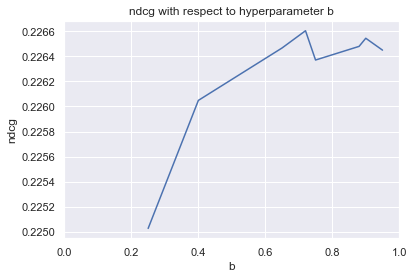

In [41]:
# TODO (in your write-up document)

# see si650_hw2_sijuntao.pdf for the description about the observations on the performance

# You should also generate separate plots showing the performance as you change each BM25 hyperparameter (three plots total); 
# for example, one plot would have NDCG on the y-axis and b on the x-axis and show NDCG changes relative the value of 𝑏. 
# Use a line plot for this.

# for hyperparameter b

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = bm25_b_sets.copy()
df["b_val"] = df["name"].str[-4:].astype(float)

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(6, 4))
plot = sns.lineplot(data = df, x = "b_val", y = "ndcg" )
ax.set_xlim(0,1)
ax.set_xlabel("b")
ax.set_ylabel("ndcg")
ax.set_title("ndcg with respect to hyperparameter b")

Text(0.5, 1.0, 'ndcg with respect to hyperparameter k1')

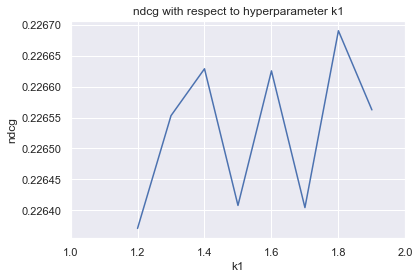

In [42]:
df = bm25_k1_sets.copy()
df["k1_val"] = df["name"].str[-3:].astype(float)

fig1, ax1 = plt.subplots(figsize=(6, 4))
plot1 = sns.lineplot(data = df, x = "k1_val", y = "ndcg" )
ax1.set_xlim(1,2)
ax1.set_xlabel("k1")
ax1.set_ylabel("ndcg")
ax1.set_title("ndcg with respect to hyperparameter k1")

Text(0.5, 1.0, 'ndcg with respect to hyperparameter k3')

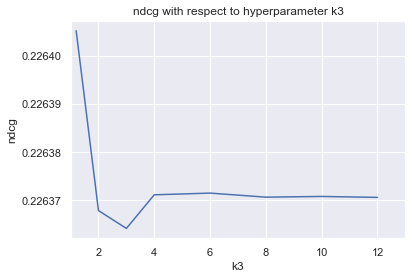

In [43]:
df = bm25_k3_sets.copy()
df["k3_val"] = df["name"].str[-3:].astype(float)

fig3, ax3 = plt.subplots(figsize=(6, 4))
plot3 = sns.lineplot(data = df, x = "k3_val", y = "ndcg" )
ax3.set_xlim(1,13)
ax3.set_xlabel("k3")
ax3.set_ylabel("ndcg")
ax3.set_title("ndcg with respect to hyperparameter k3")

## Task 4.1 Implement your custom weighting function (25 points)

The last part of the assignment will have you implement at least one retrieval function _different_ from BM25, Dirichlet Prior, and Pivoted Length Normalization (and any variations of these). You will be graded based on your best performing function. You’ll get full credit if your retrieval function can beat the provided baseline in the dataset, which is an untuned BM25 using PyTerrier's default parameters. By "beat,"' we mean that your implemented function and your choice of parameters should reach higher NDCG than the baseline on Kaggle for our dataset, which you can check at any time by running an Experiment with PyTerrier's BM25 implementation. _Full credit for this function depends on whether it can surpass an untuned BM25 ranking of the same dataset._

Most of your time in this part of the assignment will be spent trying to see what kinds of adjustments you can make to a ranking function improve. In past years, nearly all students have managed to outperform BM25 so it is very much possible. You are welcomed to be creative in your approaches as well. The intent of this part is to help you understand how different parts of the function help or hurt ranking, which often is a very empirical and hands-on process when trying to fine-tune a ranker for a particular dataset.

**Note:** Simply varying the value of parameters in Okapi/BM25, Dirichlet Prior or Pivoted Length Normalization does not count as a new retrieval function. The variations of any of the algorithms listed in the slides or in the textbooks also do not count as new functions.

In [44]:
def my_custom_weighting(keyFreq, posting, entryStats, collStats):
    '''
    Computes the Pivoted Normalization score of this document for a given query
    
    :param keyFrequency(float): the weight of the term in the query, usually 1 except during PRF.
    :param posting(Posting): access to the information about the occurrence of the term in the current document (frequency, document length etc).
    :param entryStats(EntryStatistics): access to the information about the occurrence of the term in the whole index (document frequency, etc.).
    :param collStats(CollectionStatistics): access to the information about the index as a whole (number of documents, etc).
    :return: the Pivoted Normalization score of this document for the given query
    '''
    N = collStats.getNumberOfDocuments()         # the total number of documents in the collection
    df = entryStats.getDocumentFrequency()       # the number of documents that the term occurs in
    k = 2.2
    c_t_D = posting.getFrequency()               # the frequency of the term in the current document, in tokens
    Ld = posting.getDocumentLength()             # the length of the document of the current posting in tokens
    Lavg = collStats.getAverageDocumentLength()  # the documents' average length
    c_t_Q = keyFreq                              # the frequency of the term in the query
    cf = entryStats.getFrequency()               # the frequency (total number of occurrences) of the term
    tot_num = collStats.getNumberOfUniqueTerms() # the total number of unique terms in the collection
    
    variant2_TF = c_t_D * math.log(1.0 + (k * Lavg) / Ld)
    QTF = c_t_Q
    ln2_IDF = math.log(math.e,2) * math.log((N+1)/(df+0.5))   
    CF =  (cf + 1) / (df * (variant2_TF + 1))


    sim_term = ln2_IDF * variant2_TF * QTF * CF
    return sim_term

### Task 4.2 Describe what your function does and why you designed it that way (10 points)
=

In the write-up document, write a paragraph of at least five sentences **explaining** what your function does, how you designed in, and why you decide to choose those hyperparameter values. You will lose points if you cannot explain why your function can reach a higher performance. You can use the constraints we discussed at the end of Lecture 4 too if those are helpful for motivating particular design choices.

In [45]:
# TODO in separate document

# see si650_hw2_sijuntao.pdf

### Task 4.3 Build the index for our test collection (0 points, but necessary for 4.1)

In the earlier tasks, we used NFCorpus which is for medical IR. What if we switched the domain slightly? For Task 4, we'll use the [CORD19 dataset](https://github.com/allenai/cord19), which is an IR dataset for Covid-19 questions created by AI2. Please download the dataset from the [Kaggle InClass competition site](https://www.kaggle.com/t/46e34d98356c4ae7b91517a6564a7979). Please do not download this data from other sources as this might hurt your final performance. You are welcome to adjust the preprocessing steps to give you better performance.

In [46]:
queries_dataset = pd.read_csv("queries.csv")
cord19_dataset = pd.read_csv("documents.csv").rename(columns = {"doc_id":"docno","document":"text"})

index_dir = './c19_df_index'
indexer = pt.DFIndexer(index_dir, overwrite=True)
index_ref = indexer.index(cord19_dataset["text"], cord19_dataset["docno"])
index_ref.toString()

19:18:30.440 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (8is9x9sc) - further warnings are suppressed
19:19:34.217 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 17 empty documents


'./c19_df_index/data.properties'

In [47]:
index_df = pt.IndexFactory.of(index_ref)
print(index_df.getCollectionStatistics().toString())

Number of documents: 171332
Number of terms: 156504
Number of postings: 11120054
Number of fields: 0
Number of tokens: 17546619
Field names: []
Positions:   false



### Task 4.4 Upload rankings for CORD19 to the KaggleInClass (0 points, but necessary for 4.1)

Finally, let's see how your custom ranking function does! Use your custom weighting to score the documents for each query in CORD 19 below. Upload your relevance judgments to the [Kaggle InClass leaderboard](https://www.kaggle.com/t/46e34d98356c4ae7b91517a6564a7979) to see how well it works. Using your best parameters, for each query, report the most relevant five documents, using their document ID. A sample submission for just one query would look like the following as a table (you submit a .csv file):

| QueryId | DocumentId | 
| --- | --- | 
| 116 | 1502 | 
| 116 | 6437 | 
| 116 | 2322 |
| 116 | 6087 |
| 116 | 2978 |


In [48]:
# TODO
mc_wt_c19 = pt.BatchRetrieve(index_df, wmodel=my_custom_weighting)

first_q = queries_dataset.loc[0,"query"]
final_df = mc_wt_c19(first_q).head(5).loc[:,["docno"]]
final_df["qid"] = [0+1] *5

for i in range(1, len(queries_dataset)):
    temp_q = queries_dataset.loc[i,"query"]
    temp_df = mc_wt_c19(temp_q).head(5).loc[:,["docno"]]
    temp_df["qid"] = [i+1] *5
    final_df = pd.concat([final_df, temp_df])
    
final_df

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/transformer.py:269: FutureWarning: 

/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
/Users/junsi/opt/anaconda3/lib/python3.9/site-packages/pyterrier/transformer.py:269: FutureWarning: 

,docno,qid
0,8ccl9aui,1
1,75773gwg,1
2,ne5r4d4b,1
3,es7q6c90,1
4,4dtk1kyh,1
...,...,...
0,30dhqh0g,50
1,xbze5s3c,50
2,fbpdyg2i,50
3,4nrpcado,50


In [49]:
final_df = final_df[["qid","docno"]]
final_df.to_csv("final_best_v3.csv",index = False)